**Jagung V 6**
* With InceptionV3 Pre-Trained Model



**Metrics:**
* Test loss: 0.27040714025497437
* Test accuracy: 0.8923611044883728

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models,layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D
from keras.optimizers import Adam, RMSprop
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# import os
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
tf.keras.backend.clear_session()

In [4]:
# import shutil
# shutil.rmtree("Jagung-data")

%pip install split-folders

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [31]:
# Split train test 
import splitfolders

#splitfolders.ratio("/kaggle/input/agronify-dataset/DiseasedPlants/Pertanian/Jagung", output="Jagung-data", seed=42, ratio=(.8, .1,.1), group_prefix=None)
splitfolders.ratio("../../../Dataset/UsedDataset/DiseasedPlants/Pertanian/Jagung", output="Jagung-data", seed=42, ratio=(.7, .1,.2), group_prefix=None)


Copying files: 4787 files [00:02, 1641.94 files/s]


In [32]:
training_dir = os.path.join('Jagung-data', 'train')
testing_dir = os.path.join('Jagung-data', 'test')
validating_dir = os.path.join('Jagung-data', 'val')

In [33]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	training_dir,
    shuffle=True,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

num_classes = train_generator.num_classes

validation_generator = validation_datagen.flow_from_directory(
	validating_dir,
	target_size=(224,224),
    shuffle=True,
	class_mode='categorical',
  batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 3828 images belonging to 4 classes.
Found 1431 images belonging to 4 classes.
Found 1440 images belonging to 4 classes.


In [34]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)

{'Corn__common_rust': 0, 'Corn__gray_leaf_spot': 1, 'Corn__healthy': 2, 'Corn__northern_leaf_blight': 3}
['Corn__common_rust', 'Corn__gray_leaf_spot', 'Corn__healthy', 'Corn__northern_leaf_blight']


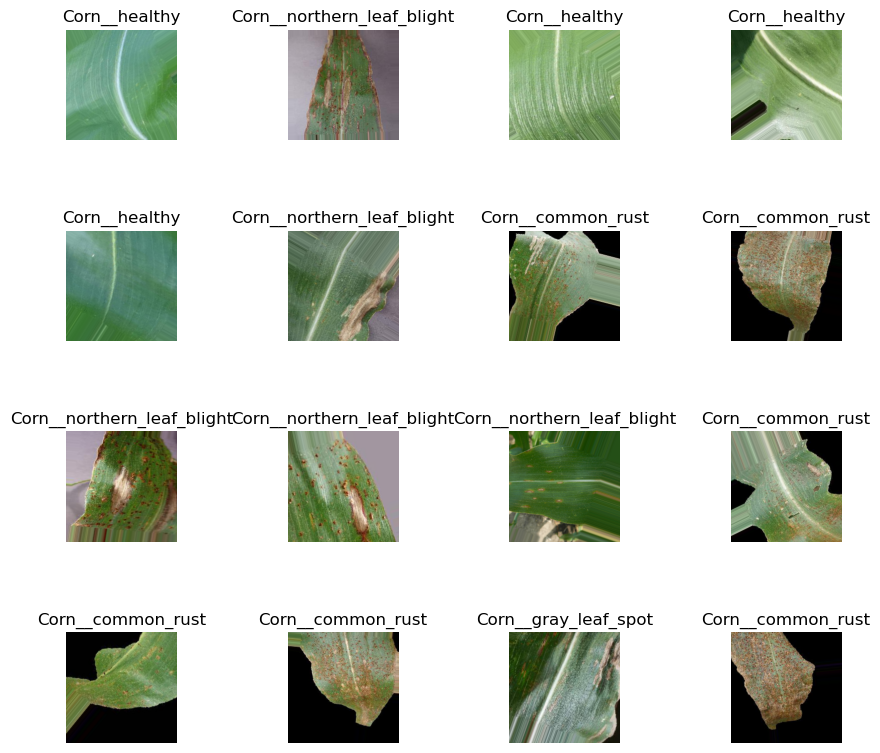

In [35]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()


In [36]:
# Define Callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>=0.98):   
            keys = list(logs.keys())
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))
            self.model.stop_training = True
            
# define object from CustomCallback Class
callbacks = CustomCallback()

In [37]:
def generator_to_dataset(generator):
    output_types = (tf.float32, tf.float32)
    output_shapes = (tf.TensorShape([None, 224, 224, 3]), tf.TensorShape([None, generator.num_classes]))

    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=output_types,
        output_shapes=output_shapes
    )

    return dataset

train_dataset = generator_to_dataset(train_generator)
validation_dataset = generator_to_dataset(validation_generator)
testing_dataset = generator_to_dataset(testing_generator)

buffer_size = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
validation_dataset = validation_dataset.prefetch(buffer_size=buffer_size)
testing_dataset = testing_dataset.prefetch(buffer_size=buffer_size)

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate

def inception_block(previous_layer, filters):
    tower1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(previous_layer)
    tower1 = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(tower1)

    tower2 = Conv2D(filters[2], (1, 1), padding='same', activation='relu')(previous_layer)
    tower2 = Conv2D(filters[3], (5, 5), padding='same', activation='relu')(tower2)

    tower3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(previous_layer)
    tower3 = Conv2D(filters[4], (1, 1), padding='same', activation='relu')(tower3)

    tower4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(previous_layer)

    # Concatenate the output of the towers
    output = Concatenate(axis=-1)([tower1, tower2, tower3, tower4])

    return output

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_98 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 128)     

In [40]:
learning_rate = 0.01

model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

In [41]:
history = model.fit(train_generator, 
                    epochs=50,
                    validation_data = validation_generator, 
                    verbose = 1, 
                    callbacks=[callbacks], 
                    validation_steps=3)

Epoch 1/50
120/120 [==============================] - 115s 948ms/step - loss: 6.6129 - accuracy: 0.4329 - val_loss: 0.9436 - val_accuracy: 0.4583
Epoch 2/50
120/120 [==============================] - 94s 783ms/step - loss: 0.9336 - accuracy: 0.4916 - val_loss: 1.0068 - val_accuracy: 0.4896
Epoch 3/50
120/120 [==============================] - 95s 793ms/step - loss: 0.9382 - accuracy: 0.4893 - val_loss: 0.9813 - val_accuracy: 0.4479
Epoch 4/50
120/120 [==============================] - 94s 780ms/step - loss: 0.9324 - accuracy: 0.4958 - val_loss: 0.9189 - val_accuracy: 0.5312
Epoch 5/50
120/120 [==============================] - 99s 820ms/step - loss: 0.9210 - accuracy: 0.4862 - val_loss: 0.8508 - val_accuracy: 0.5312
Epoch 6/50
120/120 [==============================] - 102s 845ms/step - loss: 0.9431 - accuracy: 0.4893 - val_loss: 1.5059 - val_accuracy: 0.5521
Epoch 7/50
120/120 [==============================] - 101s 840ms/step - loss: 0.9411 - accuracy: 0.4854 - val_loss: 0.9620 - val

KeyboardInterrupt: 

In [22]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

23/23 [==============================] - 27s 1s/step - loss: 0.2704 - accuracy: 0.8924
Test loss: 0.27040714025497437 / Test accuracy: 0.8923611044883728


In [23]:
predictions = model.predict(testing_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = testing_generator.classes
class_labels = list(testing_generator.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes, predicted_classes, target_names=class_labels))
print(confusion_matrix(true_classes, predicted_classes))



23/23 [==============================] - 25s 1s/step
                            precision    recall  f1-score   support

         Corn__common_rust       0.29      0.31      0.30       394
      Corn__gray_leaf_spot       0.23      0.28      0.25       329
             Corn__healthy       0.24      0.24      0.24       349
Corn__northern_leaf_blight       0.26      0.19      0.22       368

                  accuracy                           0.25      1440
                 macro avg       0.25      0.25      0.25      1440
              weighted avg       0.26      0.25      0.25      1440

[[121 103 100  70]
 [ 91  91  76  71]
 [100 106  83  60]
 [108 104  85  71]]


Potato__early_blight: 54 true positives, 6 false positives, and 51 false negatives.

Potato__healthy: 0 true positives, 8 false positives, and 8 false negatives.

Potato__late_blight: 50 true positives, 10 false positives, and 50 false negatives.


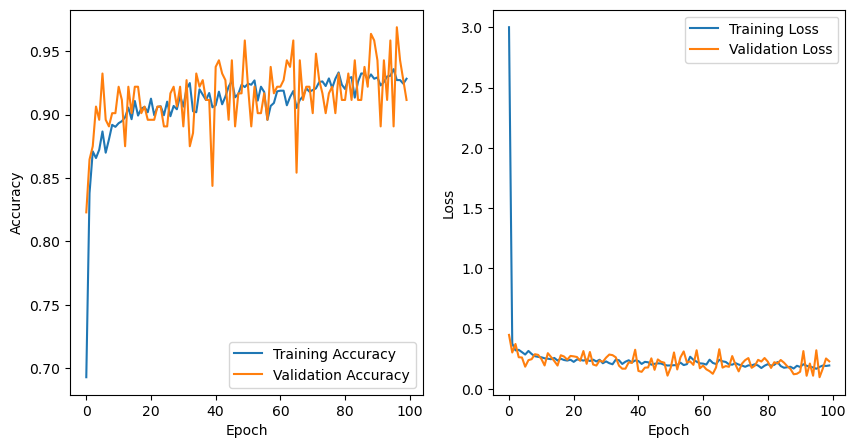

In [24]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

2/2 [==============================] - 2s 495ms/step


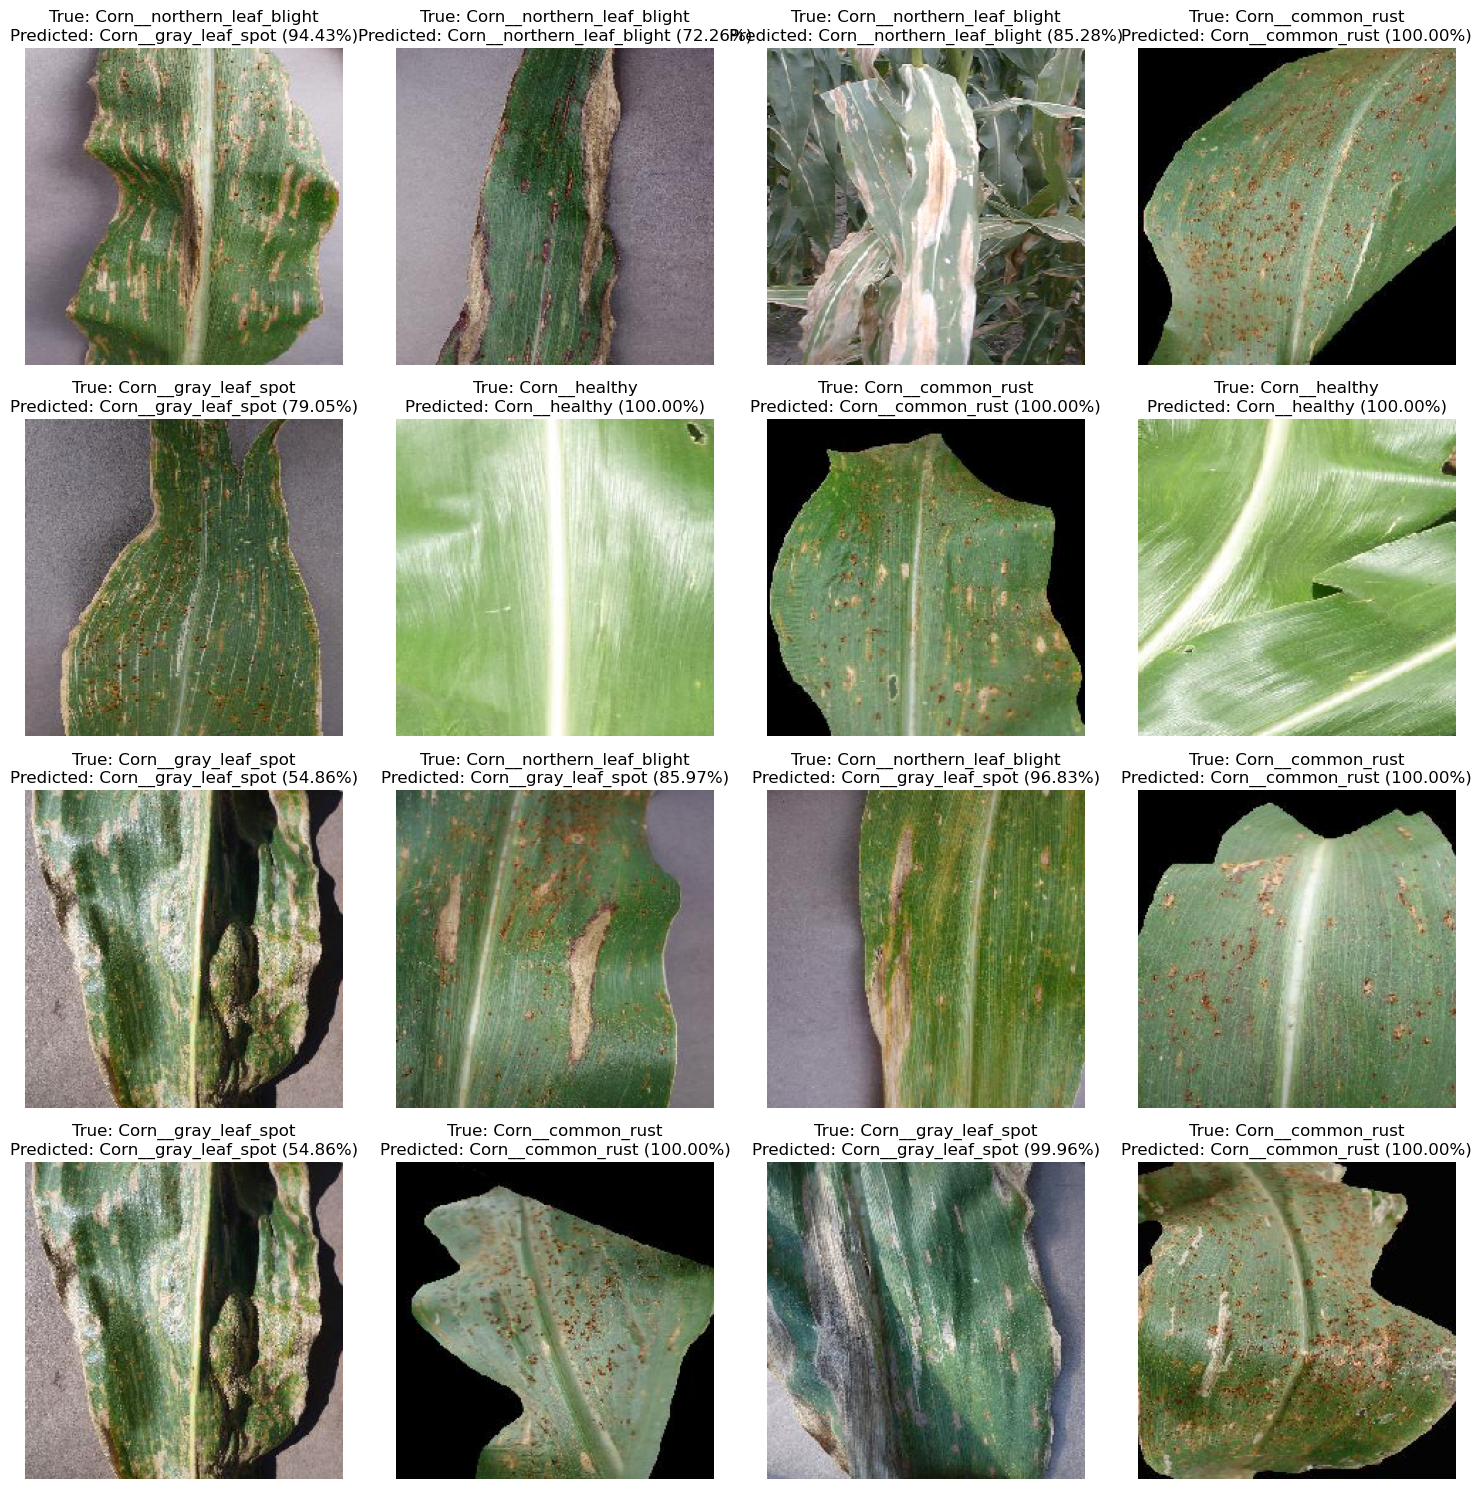

In [25]:
def plot_images(images, true_labels, predicted_labels, predicted_probs):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]} ({predicted_probs[i]:.2%})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

images, labels = next(iter(testing_generator))
predicted_probs = model.predict(images)
predicted_labels = [class_labels[i] for i in np.argmax(predicted_probs, axis=1)]
true_labels = [class_labels[i] for i in np.argmax(labels, axis=1)]
predicted_probs = np.max(predicted_probs, axis=1)

plot_images(images, true_labels, predicted_labels, predicted_probs)


Found 3828 images belonging to 4 classes.
1/1 [==============================] - 0s 63ms/step


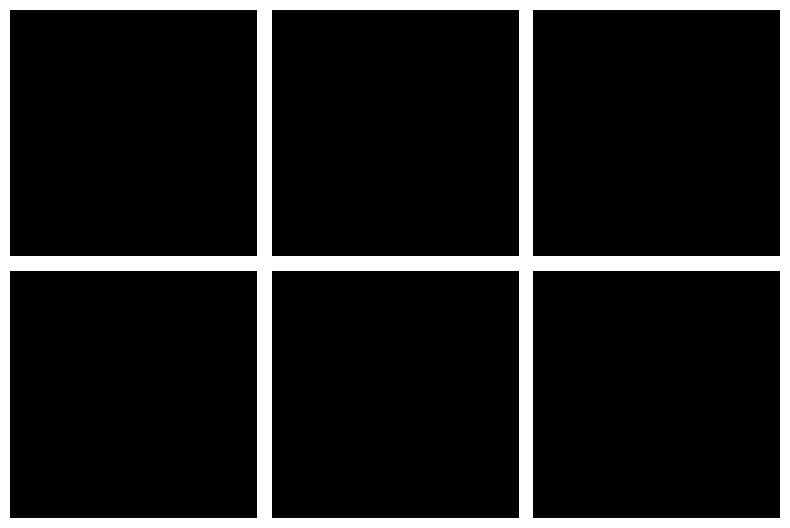

1/1 [==============================] - 0s 26ms/step


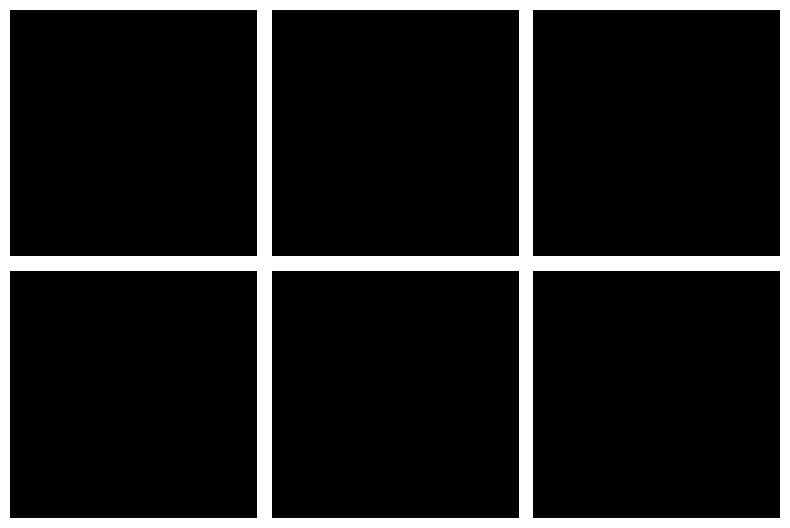

1/1 [==============================] - 0s 29ms/step


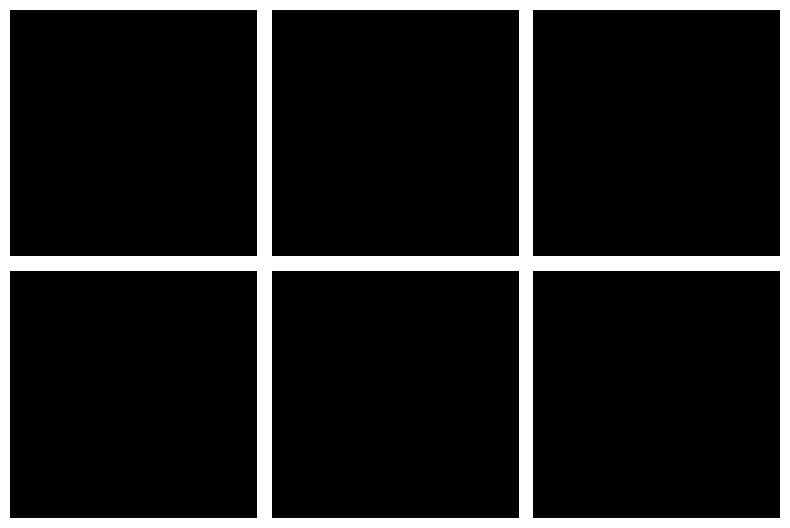

1/1 [==============================] - 0s 23ms/step


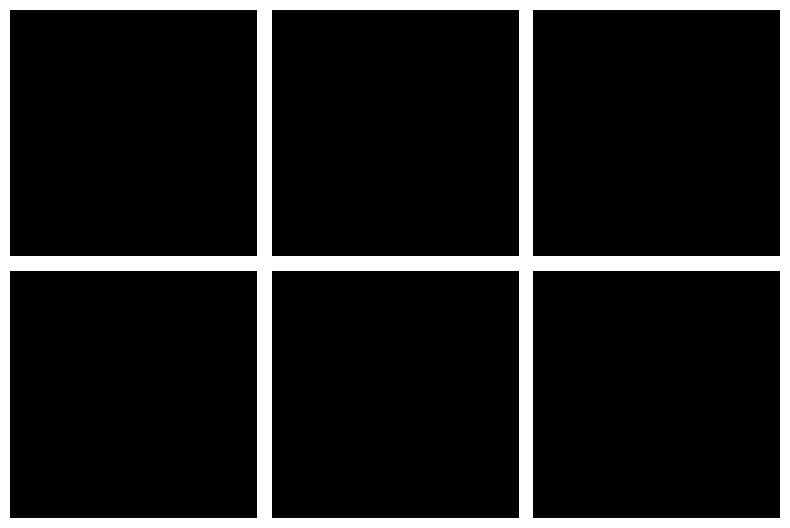

1/1 [==============================] - 0s 23ms/step


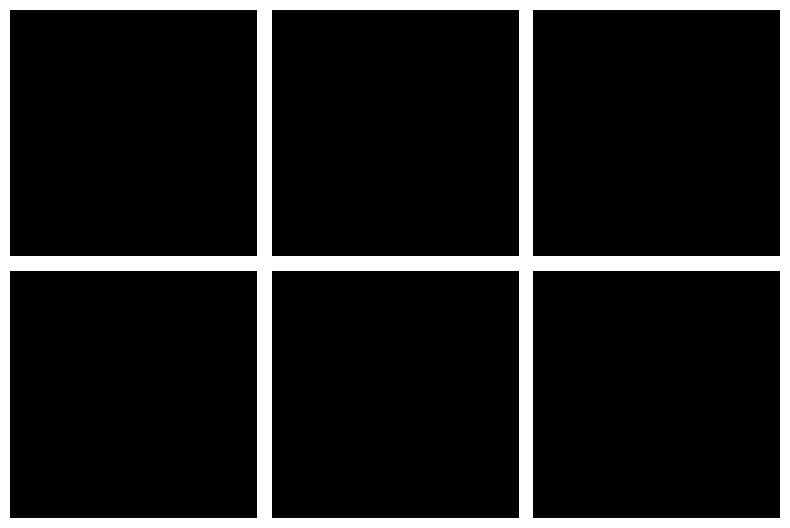

1/1 [==============================] - 0s 24ms/step


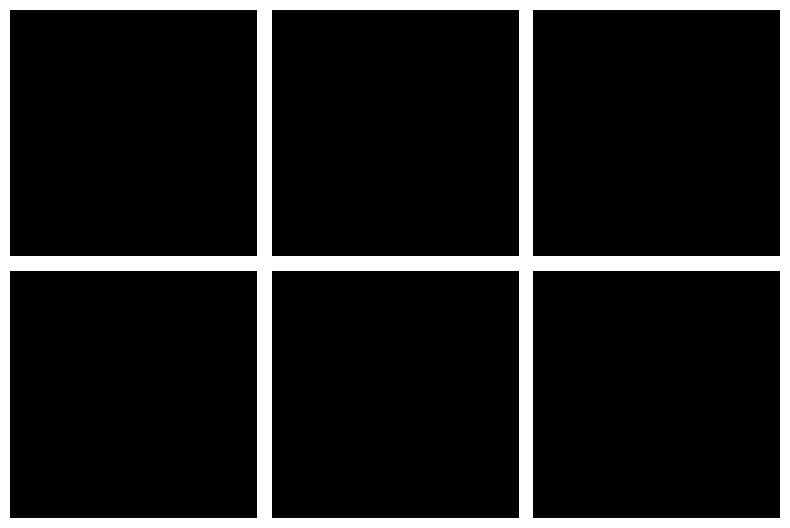

1/1 [==============================] - 0s 23ms/step


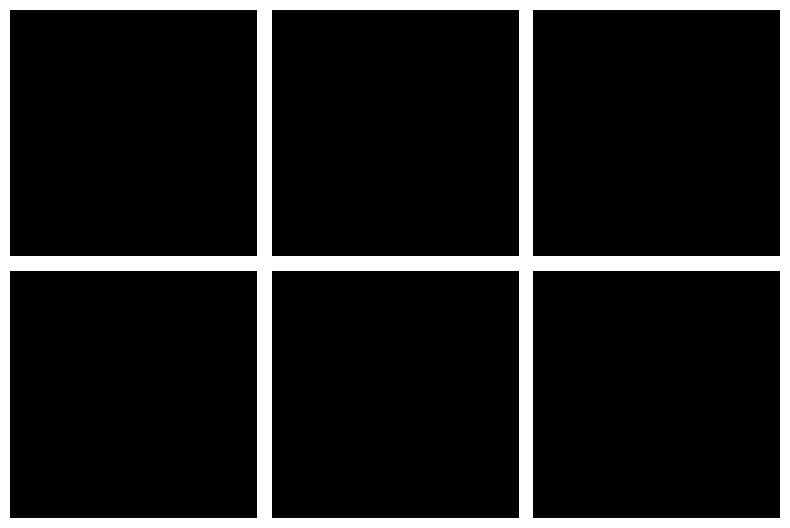

1/1 [==============================] - 0s 24ms/step


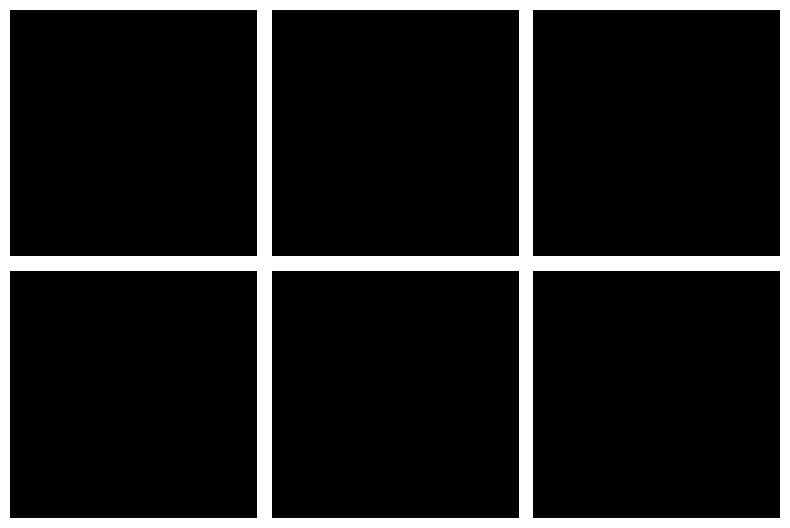

1/1 [==============================] - 0s 23ms/step


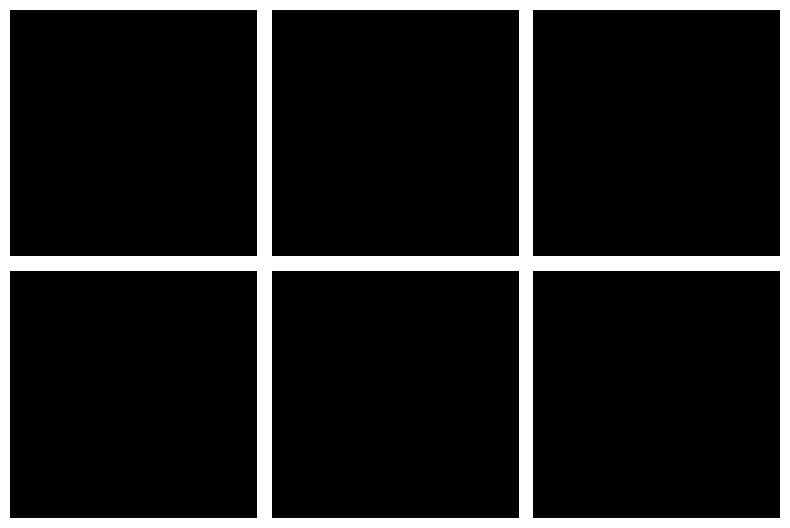

1/1 [==============================] - 0s 20ms/step


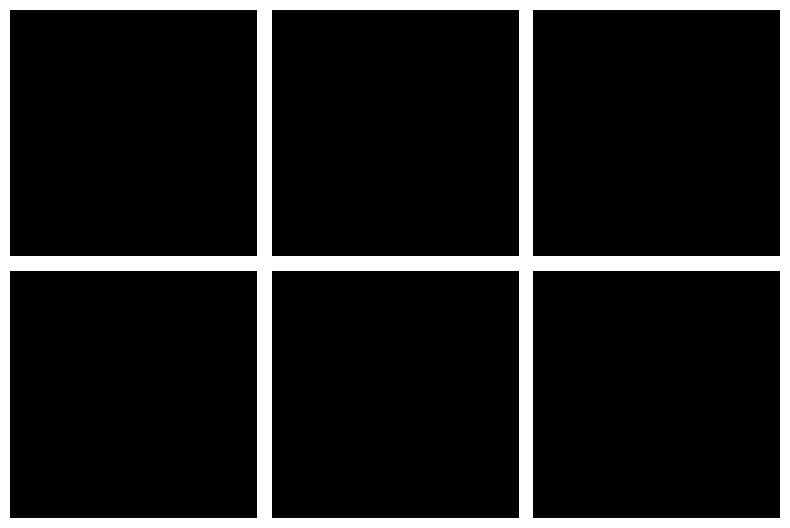

In [42]:
# Use the training_datagen defined earlier to apply data augmentation
# and create a generator with a batch size of 10
future_maps_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=10
)

# Retrieve 10 images from the generator
images, labels = next(future_maps_generator)

# Get the predicted class probabilities for each image
pred_probs = model.predict(images)

# Get the predicted and actual class names for each image
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
pred_classes = [class_names[np.argmax(pred_probs[i])] for i in range(len(images))]
actual_classes = [class_names[np.argmax(labels[i])] for i in range(len(images))]

layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Visualize the feature maps for each image along with the predicted and actual class names
for idx, image in enumerate(images):
    # Expand dimensions for single image prediction
    image = np.expand_dims(image, axis=0)

    # Get the feature maps for the current image
    activations = activation_model.predict(image)

    # Plot the feature maps and class names
    plt.figure(figsize=(8, 8))
    for i in range(len(activations)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(activations[i][0, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [43]:
model.save('jagungNewV1.h5')